# Bienvenue à la OnSSET Notebook

Cette interface est construite sur le outil [OnSSET](http://www.onsset.org/) développé par la division KTH d'Energy Systems pour fournir un moyen simple et rapide de générer des scénarios d'investissement en électrification.

#### Commencez par importer le code

In [197]:
from onsset import *
import os
from IPython.display import display, Markdown, HTML
%matplotlib inline

# 1. Sélection des données SIG

Tout d'abord, exécutez la cellule ci-dessous pour parcourir le répertoire dans lequel se trouve votre fichier CSV d'entrée et sélectionnez le fichier d'entrée. 

In [198]:
import tkinter as tk
from tkinter import filedialog, messagebox
from openpyxl import load_workbook
root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)
messagebox.showinfo('OnSSET', 'Ouvrez le fichier dentrée avec les données SIG extraites')
input_file = filedialog.askopenfilename()

onsseter = SettlementProcessor(input_file)
onsseter.df['IsUrban'] = 0
onsseter.df['Conflict'] = 0
onsseter.df['PerCapitaDemand'] = 0

# 2. Période de modélisation et taux d'électrification cible

Définissez ensuite la période de modélisation et le taux d'électrification à atteindre à la fin de l'analyse. Plus bas, vous définirez également une année et un objectif intermédiaires.

In [199]:
start_year = 2018
end_year = 2030

electrification_rate_target = 1 # Par exemple. 1 pour un taux d'électrification de 100% ou 0,80 pour un taux d'électrification de 80% 

#### Niveau cible de demande d'électricité
Ensuite, entrez le niveau cible (niveau d'accès à l'électricité) pour les ménages urbains et ruraux respectivement. Cela peut prendre une valeur comprise entre 1 (niveau d'accès à l'électricité le plus bas) et 5 (niveau d'accès à l'électricité le plus élevé) comme dans ESMAPs Multi-Tier Framework for Measuring Electricity Access (Trouvé <a href="https://www.esmap.org/node/55526" target="_blank">ici</a>). 

In [200]:
urban_target_tier = 6
rural_target_tier = 6

#### Objectif de taux d'électrification intermédiaire
Le modèle est configuré pour fonctionner en deux étapes. Saisissez l'année cible intermédiaire et le taux d'électrification cible pour cette année.

In [201]:
intermediate_year = 2025
intermediate_electrification_target = 0.75 # Par exemple. pour un taux d'électrification cible de 75%, entrez 0,75

#### Spécifications de la réseau
Cette partie peut être utilisée pour imposer des restrictions ou des extensions forcées du réseau. 

In [202]:
# Distance tampon (km) du réseau de grille actuel pour une connexion automatique au réseau.
auto_intensification = 0

# Il s'agit du nombre maximal de nouveaux ménages pouvant être connectés au réseau en un an (en milliers) par pas de temps
annual_new_grid_connections_limit = {intermediate_year: 999999999,
                                     end_year: 999999999}

# Il s'agit de la capacité de production maximale qui peut être ajoutée au réseau en un an (MW)
annual_grid_cap_gen_limit = {intermediate_year: 999999999,
                             end_year: 999999999}

# 3. Entrez les données spécifiques au pays

En plus des options ci-dessus, l'utilisateur peut personnaliser un grand nombre de variables décrivant l'environnement socio-économique-technologique du pays sélectionné.

**Remarque!** La plupart des valeurs d'entrée doivent représenter des estimations pour la variable valable tout au long de la période de modélisation, c'est-à-dire **NE PAS** valeurs actuelles.

### a. Composantes démographiques et sociales

In [203]:
pop_start_year = 6000000      ### Écrivez la population dans l'année de base (par exemple 2018)
end_year_pop = 8000000        ### Écrivez la population à la fin de l'année de l'analyse (par exemple 2030)

urban_ratio_start_year = 0.7   ### Écrire le ratio de population urbaine dans l'année de base (par exemple 2018)
urban_ratio_end_year = 0.75     ### Écrire le ratio de population urbaine à la fin de l'année (par exemple 2030)

num_people_per_hh_urban = 5     ### Écrivez le nombre de personnes par ménage urbain prévu pour la fin de l'année (par exemple 2030)
num_people_per_hh_rural = 6   ### Écrivez le nombre de personnes par ménage rural prévu pour la fin de l'année (par exemple 2030)

elec_ratio_start_year = 0.19   ### Écrivez le taux d'électrification dans l'année de base (par exemple 2018)
urban_elec_ratio = 0.40       ### Écrire le taux d'électrification urbaine dans l'année de base (par exemple 2018)
rural_elec_ratio = 0.01         ### Écrire le taux d'électrification rurale dans l'année de base (par exemple 2018)

### b. Spécifications et coûts technologiques

La cellule ci-dessous contient toutes les informations utilisées pour calculer les coûts nivelés pour toutes les technologies, y compris le réseau. Ces valeurs par défaut doivent être mises à jour pour refléter les valeurs les plus précises du pays. Il existe actuellement 7 technologies potentielles à inclure dans le modèle:
* Grille
* Mini-réseau PV
* Mini-réseau Eolienne
* Mini-réseau hydraulique
* Mini-réseau diesel
* Systèmes autonomes PV
* Systèmes autonomes diesel

Premièrement, décidez d'inclure ou non les technologies diesel:

In [204]:
diesel_techs = 0                      ### 0 = diesel NON inclus, 1 = diesel inclus

In [205]:
grid_generation_cost = 0.05           ### Il s'agit du coût de production d'électricité du réseau (USD / kWh) comme prévu à la fin de l'année de l'analyse
grid_power_plants_capital_cost = 2000 ### Le coût en USD / kW pour les améliorations de capacité des centrales électriques raccordées au réseau
grid_losses = 0.08                     ### La fraction d'électricité perdue lors du transport et de la distribution (pourcentage) 

In [206]:
diesel_price = 0.5                   ### Il s'agit du prix du diesel en USD / litre comme prévu à la fin de l'année de l'analyse.

In [207]:
sa_diesel_capital_cost = 938          ### Coût d'investissement en diesel autonome (USD / kW) comme prévu dans les années de l'analyse
mg_diesel_capital_cost = 721          ### Coût en capital du mini-réseau diesel (USD / kW) comme prévu dans les années de l'analyse
mg_pv_capital_cost = 2950             ### Coût en capital PV du mini-réseau (USD / kW) comme prévu dans les années de l'analyse
mg_wind_capital_cost = 3750           ### Coût en capital éolien du mini-réseau (USD / kW) comme prévu dans les années de l'analyse
mg_hydro_capital_cost = 3000          ### Coût en capital hydroélectrique du mini-réseau (USD / kW) comme prévu dans les années de l'analyse

In [208]:
sa_pv_capital_cost_1 = 9620          ### Coût en capital PV autonome (USD / kW) pour les systèmes domestiques de moins de 20 W
sa_pv_capital_cost_2 = 8780          ### Coût en capital PV autonome (USD / kW) pour les systèmes domestiques entre 21 et 50 W
sa_pv_capital_cost_3 = 6380           ### Coût en capital PV autonome (USD / kW) pour les systèmes domestiques de 51 à 100 W
sa_pv_capital_cost_4 = 4470           ### Coût en capital PV autonome (USD / kW) pour les systèmes domestiques de 101 à 1 000 W
sa_pv_capital_cost_5 = 6950           ### Coût en capital PV autonome (USD / kW) pour les systèmes domestiques de plus de 1 kW

Les cellules ci-dessous contiennent des spécifications technologiques supplémentaires

In [209]:
base_to_peak = 0.8                    ### Le rapport entre la demande moyenne du réseau et la demande de pointe (fraction) 
existing_grid_cost_ratio = 0.1        ### Le coût supplémentaire par cycle d'électrification (fraction)
discount_rate = 0.08                  # Par exemple. 0,08 signifie un taux d'actualisation de 8%

# Coûts de transport et de distribution
hv_line_capacity=69 # kV
hv_line_cost=53000 # USD/km
mv_line_cost = 7000 # USD/kW
mv_line_capacity=50 # kV
mv_line_max_length=50 # km
mv_increase_rate=0.1
max_mv_line_dist = 50 # km
MV_line_amperage_limit = 8  # Ampere (A)
lv_line_capacity=0.24 #kV
lv_line_max_length=0.8 # km
lv_line_cost=4250 # USD/km
service_Transf_type=50  # kVa
service_Transf_cost=4250  # $/unit
max_nodes_per_serv_trans=300  # nombre maximal de nœuds desservis par chaque transformateur de service
hv_lv_transformer_cost=25000 # USD/unit
hv_mv_transformer_cost=25000 # USD/unit
mv_lv_transformer_cost=10000 # USD/unit
mv_mv_transformer_cost=10000 # USD/unit


# Centralized grid costs
grid_calc = Technology(om_of_td_lines=0.1,
                        distribution_losses=grid_losses,
                        connection_cost_per_hh=150,
                        base_to_peak_load_ratio=base_to_peak,
                        capacity_factor=1,
                        tech_life=30,
                        grid_capacity_investment=grid_power_plants_capital_cost,
                        grid_price=grid_generation_cost)

# Mini-grid hydro costs
mg_hydro_calc = Technology(om_of_td_lines=0.03,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capacity_factor=0.5,
                            tech_life=30,
                            capital_cost={float("inf"): mg_hydro_capital_cost},
                            om_costs=0.02,
                            )

# Mini-grid wind costs
mg_wind_calc = Technology(om_of_td_lines=0.03,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capital_cost={float("inf"): mg_wind_capital_cost},
                            om_costs=0.02,
                            tech_life=20,
                            )

# Mini-grid PV costs
mg_pv_calc = Technology(om_of_td_lines=0.03,
                        distribution_losses=0.05,
                        connection_cost_per_hh=100,
                        base_to_peak_load_ratio=0.85,
                        tech_life=20,
                        om_costs=0.02,
                        capital_cost={float("inf"): mg_pv_capital_cost}                        
                        )

# Stand-alone PV costs
sa_pv_calc = Technology(base_to_peak_load_ratio=0.9,
                        tech_life=15,
                        om_costs=0.02,
                        capital_cost={float("inf"): sa_pv_capital_cost_5,
                                      1: sa_pv_capital_cost_4,
                                      0.100: sa_pv_capital_cost_3,
                                      0.050: sa_pv_capital_cost_2,
                                      0.020: sa_pv_capital_cost_1},
                        standalone=True
                        )

# Mini-grid diesel costs
mg_diesel_calc = Technology(om_of_td_lines=0.02,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capacity_factor=0.7,
                            tech_life=15,
                            om_costs=0.1,
                            capital_cost={float("inf"): mg_diesel_capital_cost},
                            mini_grid=True)



# Stand-alone diesel costs
sa_diesel_calc = Technology(base_to_peak_load_ratio=0.9,
                            capacity_factor=0.5,
                            tech_life=10,
                            om_costs=0.1,
                            capital_cost={float("inf"): sa_diesel_capital_cost},
                            standalone=True)

Technology.set_default_values(base_year=start_year, start_year=start_year, end_year=end_year, discount_rate=discount_rate,
                             hv_line_type=hv_line_capacity, hv_line_cost=hv_line_cost, mv_line_type=mv_line_capacity,
                             mv_line_amperage_limit=MV_line_amperage_limit, mv_line_cost=mv_line_cost, lv_line_type=lv_line_capacity,
                             lv_line_cost=lv_line_cost, lv_line_max_length=lv_line_max_length, 
                             service_transf_type=service_Transf_type, service_transf_cost = service_Transf_cost,
                             max_nodes_per_serv_trans=max_nodes_per_serv_trans, mv_lv_sub_station_cost=mv_lv_transformer_cost,
                             mv_mv_sub_station_cost=mv_mv_transformer_cost, hv_lv_sub_station_cost=hv_lv_transformer_cost,
                             hv_mv_sub_station_cost=hv_mv_transformer_cost)

# 4. Importation et traitement de données SIG

OnSSET est un outil basé sur le SIG et son bon fonctionnement dépend fortement de la préparation et de l'étalonnage diligents des données géospatiales nécessaires. La cellule suivante lit le fichier CSV contenant les données SIG extraites pour le pays choisi dans la section précédente et affiche un instantané de certaines des données.

In [211]:
yearsofanalysis = [intermediate_year, end_year]

onsseter.condition_df()
onsseter.df[SET_GRID_PENALTY] = onsseter.grid_penalties(onsseter.df)
onsseter.df[SET_WINDCF] = onsseter.calc_wind_cfs()
pop_modelled, urban_modelled = onsseter.calibrate_current_pop_and_urban(pop_start_year, urban_ratio_start_year)
onsseter.project_pop_and_urban(pop_start_year, end_year_pop, end_year_pop, urban_ratio_start_year, 
                                 urban_ratio_end_year, start_year, end_year, intermediate_year)

eleclimits = {intermediate_year: intermediate_electrification_target, end_year: electrification_rate_target}
time_steps = {intermediate_year: intermediate_year-start_year, end_year: end_year-intermediate_year}

display(Markdown('#### Le fichier csv a été importé correctement. Voici un aperçu:'))
display(onsseter.df[['Country','Pop','NightLights','TravelHours','GHI','WindVel','Hydropower','HydropowerDist']].sample(7))

try: 
    onsseter.df['SADieselFuelCost2025']
except KeyError:
    for year in yearsofanalysis:
        mg_diesel_cost = {'diesel_price': diesel_price,
                          'efficiency': 0.33,
                          'diesel_truck_consumption': 33.7,
                          'diesel_truck_volume': 15000}

        sa_diesel_cost = {'diesel_price': diesel_price,
                          'efficiency': 0.28,
                          'diesel_truck_consumption': 14,
                          'diesel_truck_volume': 300}

        onsseter.diesel_cost_columns(sa_diesel_cost, mg_diesel_cost, year)


La population a été calibrée avec succès


#### Le fichier csv a été importé correctement. Voici un aperçu:

,Country,Pop,NightLights,TravelHours,GHI,WindVel,Hydropower,HydropowerDist
10876,Democratic Republic of Congo,16.407131,15.113736,1.700000,2163.0,3.184627,567.344,28.074520
3317,Democratic Republic of Congo,13.434695,0.000000,2.366667,2156.0,3.370939,161.696,21.078608
3919,Democratic Republic of Congo,13.434695,0.000000,3.000000,2131.0,2.920063,182.160,5.670830
10017,Democratic Republic of Congo,16.407131,15.113736,0.400000,2148.0,3.632374,161.696,35.905605
10813,Democratic Republic of Congo,16.407131,15.113736,1.268098,2138.0,3.948817,615.373,40.103145
9303,Democratic Republic of Congo,140.394207,32.331688,0.473863,2153.0,3.903486,227.561,15.505704
6921,Democratic Republic of Congo,59.598565,27.450167,0.933333,2045.0,2.712474,148.304,33.473488


#### Étalonnage des colonies actuellement électrifiées

Le modèle calibre les établissements susceptibles d'être électrifiés au cours de l'année de démarrage, pour correspondre aux valeurs statistiques nationales définies ci-dessus. Un règlement est considéré comme électrifié s'il remplit toutes les conditions suivantes:
- A plus de lumières nocturnes que le seuil défini (ce paramètre est défini sur 0 par défaut)
- Est plus proche du réseau de distribution existant que la limite de distance
- A plus de population que le seuil

Définissez d'abord les seuils. Exécutez ensuite l'étalonnage et vérifiez si les résultats semblent corrects. Sinon, redéfinissez ces seuils et exécutez à nouveau.

In [165]:
min_night_lights = 0    ### 0 Indique l'absence de veilleuse, tandis que n'importe quel nombre ci-dessus fait référence à l'intensité des veilleuses
min_pop = 100      ### Population de peuplement au-dessus de laquelle on peut supposer qu'elle pourrait être électrifiée
   
max_mv_line_distance = 20 ### Distance en km du réseau de distribution existant en dessous de laquelle nous pouvons supposer qu'un règlement pourrait être électrifié
max_hv_line_distance = 25

elec_modelled, urban_internal_elec_ratio, rural_internal_elec_ratio = onsseter.elec_current_and_future(elec_ratio_start_year, 
                                                                                                       urban_elec_ratio, 
                                                                                                       rural_elec_ratio, 
                                                                                                       start_year,
                                                                                                       min_night_lights=min_night_lights, 
                                                                                                       min_pop=min_pop, 
                                                                                                       max_transformer_dist=2, 
                                                                                                       max_mv_dist=max_mv_line_distance, 
                                                                                                       max_hv_dist=max_hv_line_distance) 

Calibrating using HV lines
Le taux délectrification modélisé est 0.19. Le taux délectrification urbain modélisé est 0.27 Le taux délectrification rural modélisé est 0.01


La figure ci-dessous montre les résultats de l'étalonnage. Les colonies en **bleu** sont considérées comme (au moins en partie) électrifiées dès le début de l'analyse, tandis que les colonies en **jaune** ne sont pas encore électrifiées. Réexécuter l'étape d'étalonnage avec différentes valeurs initiales peut modifier la carte ci-dessous.

<Figure size 2160x2160 with 0 Axes>

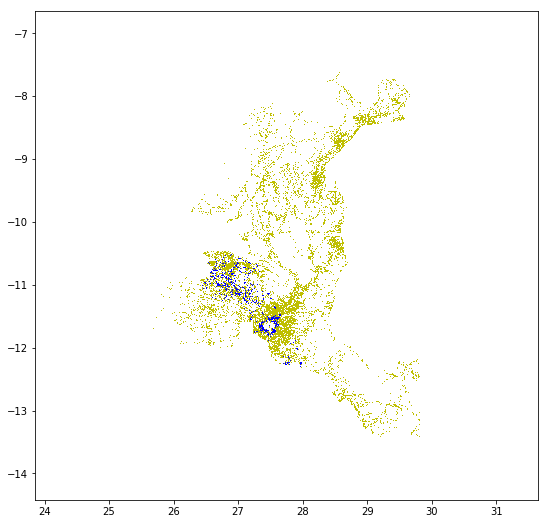

<Figure size 2160x2160 with 0 Axes>

In [166]:
from matplotlib import pyplot as plt
colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']
plt.figure(figsize=(9,9))
plt.plot(onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==0, SET_X_DEG], onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==0, SET_Y_DEG], 'y,')
plt.plot(onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==1, SET_X_DEG], onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==1, SET_Y_DEG], 'b,')
if onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min() > onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min():
    plt.xlim(onsseter.df[SET_X_DEG].min() - 1, onsseter.df[SET_X_DEG].max() + 1)
    plt.ylim((onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 - 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) - 1, (onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 + 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) + 1)
else:
    plt.xlim((onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 - 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) - 1, (onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 + 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) + 1)
    plt.ylim(onsseter.df[SET_Y_DEG].min() -1, onsseter.df[SET_Y_DEG].max() +1)
plt.figure(figsize=(30,30))

# 5. Définir la demande

Ce morceau de code définit la demande d'électricité cible dans la région/le pays. La demande d'électricité résidentielle est définie comme kWh / ménage / an, tandis que toutes les autres demandes sont définies comme kWh/habitant/an. Notez qu'à l'heure actuelle, toutes les demandes d'utilisation productive sont définies sur 0 par défaut.

In [167]:
# Définir les objectifs annuels d'électricité domestique à choisir
tier_1 = 38.7  # 38.7 fait référence à kWh/ménage/an. 
tier_2 = 219
tier_3 = 803
tier_4 = 2117
tier_5 = 2993

onsseter.prepare_wtf_tier_columns(num_people_per_hh_rural, num_people_per_hh_urban, tier_1, tier_2, tier_3, tier_4, tier_5)

In [168]:
onsseter.df[SET_EDU_DEMAND] = 0           # Demande d'établissements d'enseignement (kWh / habitant / an)
onsseter.df[SET_HEALTH_DEMAND] = 0        # Demande d'établissements de santé (kWh / habitant / an)
onsseter.df[SET_COMMERCIAL_DEMAND] = 0    # Demande d'activités commerciales (kWh / habitant / an)
onsseter.df[SET_AGRI_DEMAND] = 0          # Demande d'activités agricoles (kWh / habitant / an)
productive_demand = 0 # 1 si la demande productive est définie et doit être incluse, sinon 0

# 6. Lancer une exécution de scénario, qui calcule et compare les coûts technologiques pour chaque règlement dans le pays

Sur la base du calcul précédent, ce morceau de code identifie le LCoE que chaque technologie hors réseau peut fournir, pour chaque règlement peuplé unique du pays sélectionné. La cellule prend ensuite tous les points actuellement connectés au réseau dans le pays et examine les points à une certaine distance d'eux, pour voir s'il est plus économique de les connecter au réseau, ou d'utiliser l'un des hors-réseau technologies calculées ci-dessus. Une fois que d'autres points sont connectés au réseau, le processus est répété, de sorte que de nouveaux points proches de ces points peuvent également être connectés. Cette opération est répétée jusqu'à ce qu'il n'y ait plus de nouveaux points à connecter au réseau.

In [169]:
onsseter.current_mv_line_dist()
onsseter.df.reset_index(inplace=True)

for year in yearsofanalysis:
    end_year_pop = 1
    prioritization = 2
        
    eleclimit = eleclimits[year]
    time_step = time_steps[year]
    grid_cap_gen_limit = time_step * annual_grid_cap_gen_limit[year] * 1000
    grid_connect_limit = time_step * annual_new_grid_connections_limit[year] * 1000
    
    onsseter.set_scenario_variables(year, num_people_per_hh_rural, num_people_per_hh_urban, time_step,
                                            start_year, urban_target_tier, 
                                            rural_target_tier, end_year_pop, productive_demand)

    sa_diesel_investment, sa_pv_investment, mg_diesel_investment, mg_pv_investment, mg_wind_investment, \
                                        mg_hydro_investment = onsseter.calculate_off_grid_lcoes(mg_hydro_calc, mg_wind_calc, mg_pv_calc,
                                                                                                sa_pv_calc, mg_diesel_calc,
                                                                                                sa_diesel_calc, year, end_year, time_step)
    grid_investment, grid_cap_gen_limit, grid_connect_limit = \
                                        onsseter.pre_electrification(grid_generation_cost, year, time_step, end_year, grid_calc, grid_cap_gen_limit,
                                                                     grid_connect_limit)

    onsseter.df[SET_LCOE_GRID + "{}".format(year)], onsseter.df[SET_MIN_GRID_DIST + "{}".format(year)], \
                                    onsseter.df[SET_ELEC_ORDER + "{}".format(year)], onsseter.df[SET_MV_CONNECT_DIST], grid_investment = \
                                        onsseter.elec_extension(grid_calc,
                                                                mv_line_max_length,
                                                                year,
                                                                start_year,
                                                                end_year,
                                                                time_step,
                                                                grid_cap_gen_limit,
                                                                grid_connect_limit,
                                                                auto_intensification=auto_intensification,
                                                                prioritization=prioritization,
                                                                new_investment=grid_investment)

    onsseter.results_columns(year, time_step, prioritization, auto_intensification)

    onsseter.calculate_investments(sa_diesel_investment, sa_pv_investment, mg_diesel_investment,
                                   mg_pv_investment, mg_wind_investment,
                                   mg_hydro_investment, grid_investment, year)

    onsseter.apply_limitations(eleclimit, year, time_step, prioritization, auto_intensification)

    onsseter.calculate_new_capacity(mg_hydro_calc, mg_wind_calc, mg_pv_calc, sa_pv_calc, mg_diesel_calc,
                                                                    sa_diesel_calc, grid_calc, year)    

Le taux d'électrification atteint en 2025 est 75.0 %
Le taux d'électrification atteint en 2030 est 100.0 %


# 7. Résultats, résumés et visualisation
Une fois tous les calculs et extensions de réseau terminés, ce bloc obtient les résultats finaux sur la technologie choisie pour chaque point, la quantité de capacité à installer et son coût. Ensuite, les résumés, les graphiques et les cartes sont générés.

In [170]:
elements = []
for year in yearsofanalysis:
    elements.append("Population{}".format(year))
    elements.append("NewConnections{}".format(year))
    elements.append("Capacity{}".format(year))
    elements.append("Investment{}".format(year))

techs = ["Grid", "SA_Diesel", "SA_PV", "MG_Diesel", "MG_PV", "MG_Wind", "MG_Hydro"]

sumtechs = []
for year in yearsofanalysis:
    sumtechs.extend(["Population{}".format(year) + t for t in techs])
    sumtechs.extend(["NewConnections{}".format(year) + t for t in techs])
    sumtechs.extend(["Capacity{}".format(year) + t for t in techs])
    sumtechs.extend(["Investment{}".format(year) + t for t in techs])

summary = pd.Series(index=sumtechs, name='country')

for year in yearsofanalysis:
    code = 1
    for t in techs:
        summary.loc["Population{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL_CODE + '{}'.format(year)] == code) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_POP + '{}'.format(year)].sum()
        summary.loc["NewConnections{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL_CODE + '{}'.format(year)] == code) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_NEW_CONNECTIONS + '{}'.format(year)].sum()
        summary.loc["Capacity{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL_CODE + '{}'.format(year)] == code) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_NEW_CAPACITY + '{}'.format(year)].sum()/1000
        summary.loc["Investment{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL_CODE + '{}'.format(year)] == code) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_INVESTMENT_COST + '{}'.format(year)].sum()
        code += 1
        
index = techs + ['Total']
columns = []
for year in yearsofanalysis:
    columns.append("Population{}".format(year))
    columns.append("NewConnections{}".format(year))
    columns.append("Capacity{} (MW)".format(year))
    columns.append("Investment{} (million USD)".format(year))
                                                                                                                                           
summary_table = pd.DataFrame(index=index, columns=columns)

summary_table[columns[0]] = summary.iloc[0:7].astype(int).tolist() + [int(summary.iloc[0:7].sum())]
summary_table[columns[1]] = summary.iloc[7:14].astype(int).tolist() + [int(summary.iloc[7:14].sum())]
summary_table[columns[2]] = summary.iloc[14:21].astype(int).tolist() + [int(summary.iloc[14:21].sum())]
summary_table[columns[3]] = [round(x/1e4)/1e2 for x in summary.iloc[21:28].astype(float).tolist()] + [round(summary.iloc[21:28].sum()/1e4)/1e2]
summary_table[columns[4]] = summary.iloc[28:35].astype(int).tolist() + [int(summary.iloc[28:35].sum())]
summary_table[columns[5]] = summary.iloc[35:42].astype(int).tolist() + [int(summary.iloc[35:42].sum())]
summary_table[columns[6]] = summary.iloc[42:49].astype(int).tolist() + [int(summary.iloc[42:49].sum())]
summary_table[columns[7]] = [round(x/1e4)/1e2 for x in summary.iloc[49:56].astype(float).tolist()] + [round(summary.iloc[49:56].sum()/1e4)/1e2]

In [171]:
display(Markdown('### Summary \n Ce sont les résultats résumés pour lélectrification complète du pays sélectionné dici la dernière année'))
summary_table

### Summary 
 Ce sont les résultats résumés pour lélectrification complète du pays sélectionné dici la dernière année

,Population2025,NewConnections2025,Capacity2025 (MW),Investment2025 (million USD),Population2030,NewConnections2030,Capacity2030 (MW),Investment2030 (million USD)
Grid,4611422,3471422,38,334.34,5303666,692243,8,35.06
SA_Diesel,0,0,0,0.00,0,0,0,0.00
SA_PV,691252,691252,3,31.21,2666395,1969689,11,55.53
MG_Diesel,0,0,0,0.00,0,0,0,0.00
MG_PV,0,0,0,0.00,10398,10398,0,1.69
MG_Wind,0,0,0,0.00,0,0,0,0.00
MG_Hydro,5452,5452,0,0.24,4891,4891,0,0.18
Total,5308127,4168127,41,365.79,7985351,2677223,20,92.45


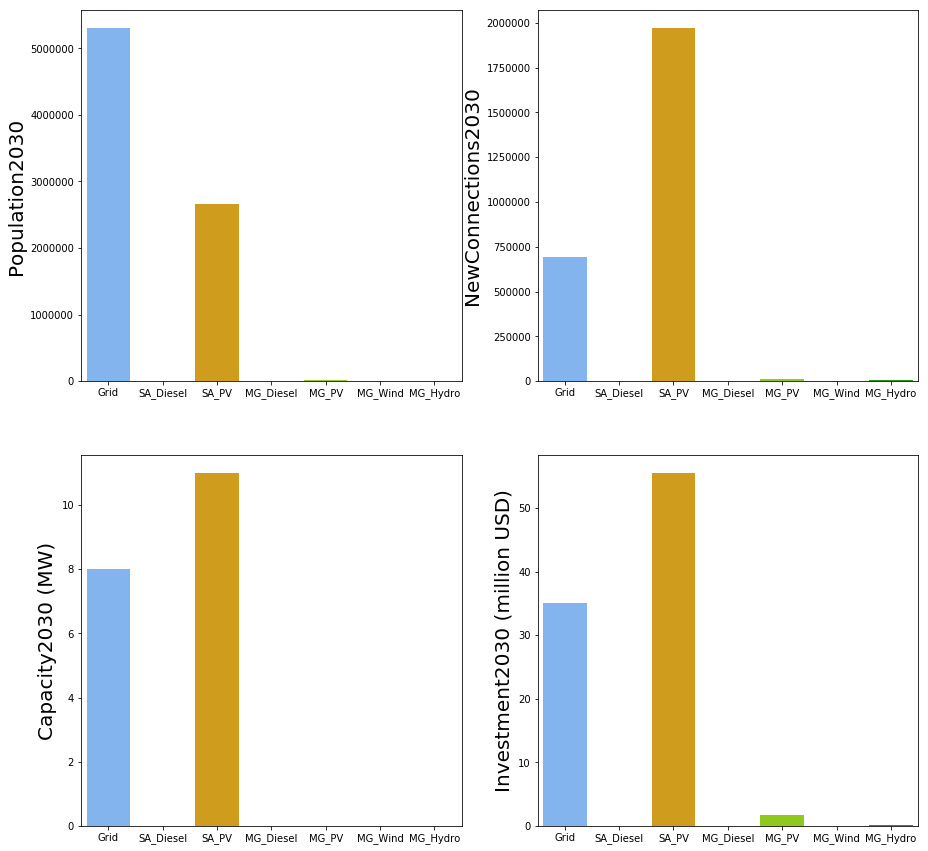

In [172]:
import matplotlib.pylab as plt
import seaborn as sns

colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']
techs_colors = dict(zip(techs, colors))

summary_plot=summary_table.drop(labels='Total',axis=0)
fig_size = [15, 15]
font_size = 10
plt.rcParams["figure.figsize"] = fig_size
f, axarr = plt.subplots(2, 2)
fig_size = [15, 15]
font_size = 10
plt.rcParams["figure.figsize"] = fig_size

sns.barplot(x=summary_plot.index.tolist(), y=columns[4], data=summary_plot, ax=axarr[0, 0], palette=colors)
axarr[0, 0].set_ylabel(columns[4], fontsize=2*font_size)
axarr[0, 0].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[5], data=summary_plot, ax=axarr[0, 1], palette=colors)
axarr[0, 1].set_ylabel(columns[5], fontsize=2*font_size)
axarr[0, 1].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[6], data=summary_plot, ax=axarr[1, 0], palette=colors)
axarr[1, 0].set_ylabel(columns[6], fontsize=2*font_size)
axarr[1, 0].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[7], data=summary_plot, ax=axarr[1, 1], palette=colors)
axarr[1, 1].set_ylabel(columns[7], fontsize=2*font_size)
axarr[1, 1].tick_params(labelsize=font_size)

<Figure size 1440x1440 with 0 Axes>

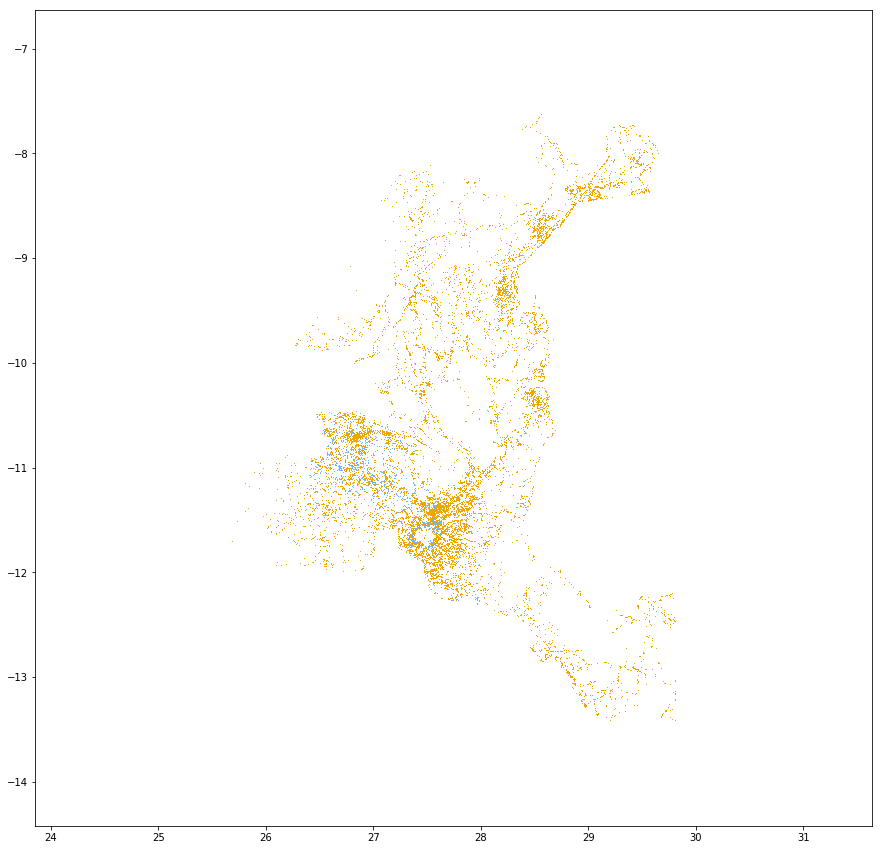

<Figure size 1440x1440 with 0 Axes>

In [173]:
from matplotlib import pyplot as plt
colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']
#plt.figure(figsize=(9,9))
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==3, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==3, SET_Y_DEG], color='#EDA800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==2, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==2, SET_Y_DEG], color='#EDD100', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==4, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==4, SET_Y_DEG], color='#1F6600', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==5, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==5, SET_Y_DEG], color='#98E600', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==6, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==6, SET_Y_DEG], color='#70A800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==7, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==7, SET_Y_DEG], color='#1FA800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==1, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==1, SET_Y_DEG], color='#73B2FF', marker=',', linestyle='none')
if onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min() > onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min():
    plt.xlim(onsseter.df[SET_X_DEG].min() - 1, onsseter.df[SET_X_DEG].max() + 1)
    plt.ylim((onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 - 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) - 1, (onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 + 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) + 1)
else:
    plt.xlim((onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 - 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) - 1, (onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 + 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) + 1)
    plt.ylim(onsseter.df[SET_Y_DEG].min() -1, onsseter.df[SET_Y_DEG].max() +1)
plt.figure(figsize=(20,20))

## 9. Exportation des résultats

Ce code génère trois fichiers csv:
 - un contenant tous les résultats du scénario créé
 - un contenant le résumé du scénario créé
 - un contenant certains si les variables d'entrée clés du scénario

Avant de continuer, veuillez écrire le nom du scénario dans la première cellule ci-dessous. passez ensuite à la cellule suivante et exécutez-la pour parcourir le répertoire dans lequel vous souhaitez enregistrer vos résultats. 

**Notez que si vous ne modifiez pas le nom du scénario, les fichiers de sortie précédents seront remplacés**

In [174]:
scenario_name = "Scenario_HV"

In [175]:
list1 = [('Start_year',start_year,'','',''), 
         ('End_year',end_year,'','',''),
         ('End year electrification rate target',electrification_rate_target,'','',''),
         ('Intermediate target year', intermediate_year,'','',''),
         ('Intermediate electrification rate target', intermediate_electrification_target,'','',''),
         ('Urban target tier', urban_target_tier, '', '', ''),
         ('Rural target tier', rural_target_tier, '', '', ''),
         ('Prioritization', prioritization,'','','1 = baseline, 2 = intensification'),
         ('Auto intensification distance', auto_intensification, '', '', 'Buffer distance (km) for automatic intensification if choosing prioritization 1'),
         ('discount_rate',discount_rate,'','',''),
         ('pop_start_year',pop_start_year,'','','the population in the base year (e.g. 2016)'),
         ('pop_end_year',end_year_pop,'','','the projected population in the end year (e.g. 2030)'),
         ('urban_ratio_start_year',urban_ratio_start_year,'','','the urban population population ratio in the base year (e.g. 2016)'),
         ('urban_ratio_end_year',urban_ratio_end_year,'','','the urban population population ratio in the end year (e.g. 2030)'),
         ('num_people_per_hh_urban',num_people_per_hh_urban,'','','the number of people per household expected in the end year (e.g. 2030)'),
         ('num_people_per_hh_rural',num_people_per_hh_rural,'','','the number of people per household expected in the end year (e.g. 2030)'),
         ('elec_ratio_start_year',elec_ratio_start_year,'','','the electrification rate in the base year (e.g. 2016)'),
         ('urban_elec_ratio',urban_elec_ratio,'','','urban electrification rate in the base year (e.g. 2016)'),
         ('rural_elec_ratio',rural_elec_ratio,'','','rural electrification rate in the base year (e.g. 2016)'),
         ('grid_generation_cost',grid_generation_cost,'','','This is the grid cost electricity USD/kWh as expected in the end year of the analysis'),
         ('grid_power_plants_capital_cost',grid_power_plants_capital_cost,'','','The cost in USD/kW to for capacity upgrades of the grid-connected power plants'),
         ('grid_losses',grid_losses,'','','The fraction of electricity lost in transmission and distribution (percentage)'),
         ('base_to_peak',base_to_peak,'','','The ratio of base grid demand to peak demand (percentage)'),
         ('existing_grid_cost_ratio',existing_grid_cost_ratio,'','','The additional cost per round of electrification (percentage)'),
         ('diesel_price',diesel_price,'','','This is the diesel price in USD/liter as expected in the end year of the analysis'),
         ('sa_diesel_capital_cost',sa_diesel_capital_cost,'','','Stand-alone Diesel capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_diesel_capital_cost',mg_diesel_capital_cost,'','','Mini-grid Diesel capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_pv_capital_cost',mg_pv_capital_cost,'','','Mini-grid PV capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_wind_capital_cost',mg_wind_capital_cost,'','','Mini-grid Wind capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_hydro_capital_cost',mg_hydro_capital_cost,'','','Mini-grid Hydro capital cost (USD/kW) as expected in the years of the analysis'),
         ('sa_pv_capital_cost_1',sa_pv_capital_cost_1,'','','Stand-alone PV capital cost (USD/kW) for household systems under 20 W'),
         ('sa_pv_capital_cost_2',sa_pv_capital_cost_2,'','','Stand-alone PV capital cost (USD/kW) for household systems between 21-50 W'),
         ('sa_pv_capital_cost_3',sa_pv_capital_cost_3,'','','Stand-alone PV capital cost (USD/kW) for household systems between 51-100 W'),
         ('sa_pv_capital_cost_4',sa_pv_capital_cost_4,'','','Stand-alone PV capital cost (USD/kW) for household systems between 101-200 W'),
         ('sa_pv_capital_cost_5',sa_pv_capital_cost_5,'','','Stand-alone PV capital cost (USD/kW) for household systems over 200 W'),
         ('mv_line_cost',mv_line_cost,'','','Cost of MV lines in USD/km'),
         ('lv_line_cost',lv_line_cost,'','','Cost of LV lines in USD/km'),
         ('mv_line_capacity',mv_line_capacity,'','','Capacity of MV lines in kW/line'),
         ('lv_line_capacity',lv_line_capacity,'','','Capacity of LV lines in kW/line'),
         ('lv_line_max_length',lv_line_max_length,'','','Maximum length of LV lines (km)'),
         ('hv_line_cost',hv_line_cost,'','','Cost of HV lines in USD/km'),
         ('mv_line_max_length',mv_line_max_length,'','','Maximum length of MV lines (km)'),
         ('hv_lv_transformer_cost',hv_lv_transformer_cost,'','','Cost of HV/MV transformer (USD/unit)'),
         ('mv_increase_rate',mv_increase_rate,'','','percentage'),
         ('max_grid_extension_dist',max_mv_line_dist,'','','Maximum distance that the grid may be extended by means of MV lines'),
         ('annual_new_grid_connections_limit', annual_new_grid_connections_limit,'','','This is the maximum amount of new households that can be connected to the grid in one year (thousands)'),
         ('grid_capacity_limit',annual_grid_cap_gen_limit,'','','This is the maximum generation capacity that can be added to the grid in one year (MW)'),
        ]
labels = ['Variable','Value', 'Source', 'Comments', 'Description']
df_variables = pd.DataFrame.from_records(list1, columns=labels)

In [176]:
messagebox.showinfo('OnSSET', 'Accédez au dossier dans lequel vous souhaitez enregistrer les sorties')

output_dir = filedialog.askdirectory()
output_dir_variables = os.path.join(output_dir, '{}_Variables.csv'.format(scenario_name))
output_dir_results = os.path.join(output_dir, '{}_Results.csv'.format(scenario_name))
output_dir_summaries = os.path.join(output_dir, '{}_Summaries.csv'.format(scenario_name))

In [177]:
# Returning the result as a csv file
onsseter.df.to_csv(output_dir_results, index=False)

# Returning the summary as a csv file
summary_table.to_csv(output_dir_summaries, index=True)

# Returning the input variables as a csv file
df_variables.to_csv(output_dir_variables, index=False)

**Exécutez les deux cellules ci-dessous pour enregistrer une carte et un graphique simples**

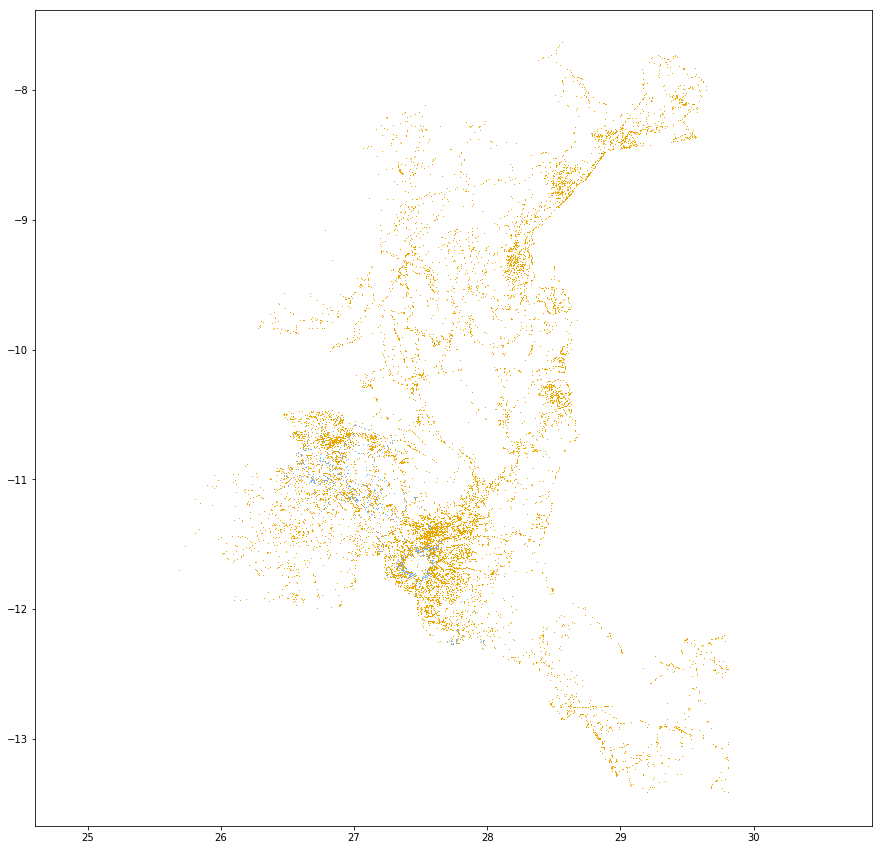

In [178]:
colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']

if onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min() > onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min():
    plt.xlim(onsseter.df[SET_X_DEG].min() - 0.25, onsseter.df[SET_X_DEG].max() + 0.25)
    plt.ylim((onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 - 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) - 0.25, (onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 + 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) + 0.25)
else:
    plt.xlim((onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 - 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) - 0.25, (onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 + 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) + 0.25)
    plt.ylim(onsseter.df[SET_Y_DEG].min() -0.25, onsseter.df[SET_Y_DEG].max() +0.25)

plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==3, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==3, SET_Y_DEG], color='#EDA800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==2, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==2, SET_Y_DEG], color='#EDD100', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==4, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==4, SET_Y_DEG], color='#1F6600', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==5, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==5, SET_Y_DEG], color='#98E600', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==6, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==6, SET_Y_DEG], color='#70A800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==7, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==7, SET_Y_DEG], color='#1FA800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==1, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==1, SET_Y_DEG], color='#73B2FF', marker=',', linestyle='none')

#plt.figure(figsize=(20,20))
fig_path = os.path.join(output_dir, '{}_Technologies_Map.png'.format(scenario_name))
plt.savefig(fig_path)

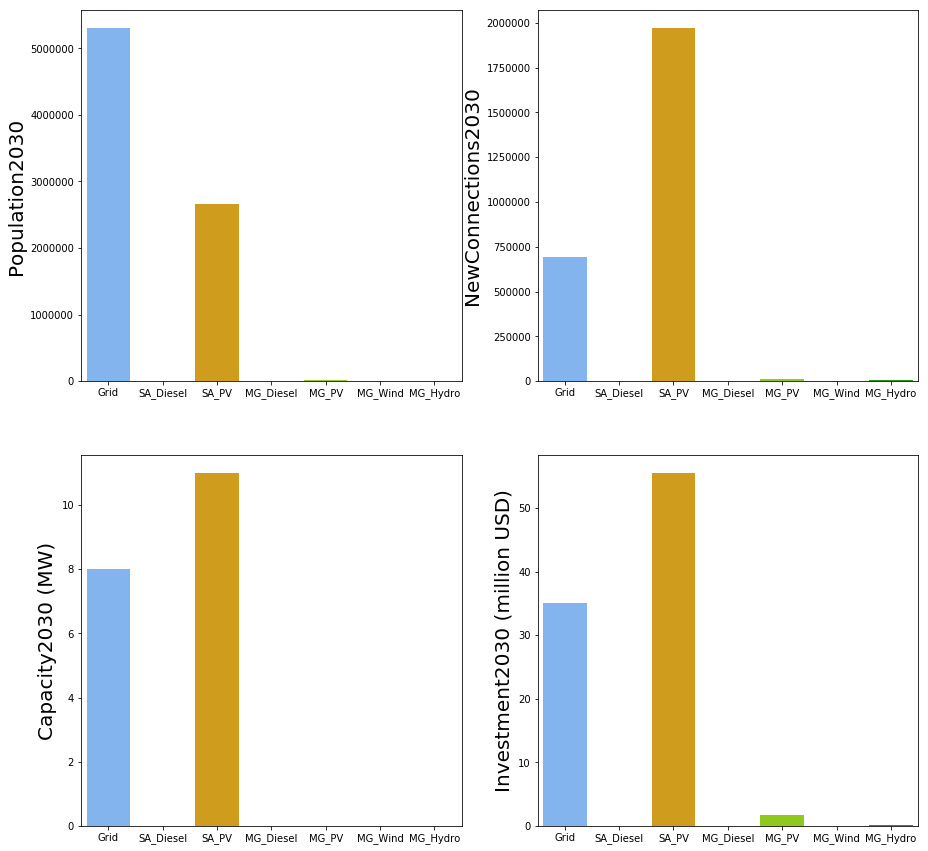

In [179]:
import matplotlib.pylab as plt
import seaborn as sns

colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']
techs_colors = dict(zip(techs, colors))

summary_plot=summary_table.drop(labels='Total',axis=0)
fig_size = [15, 15]
font_size = 10
plt.rcParams["figure.figsize"] = fig_size
f, axarr = plt.subplots(2, 2)
fig_size = [15, 15]
font_size = 10
plt.rcParams["figure.figsize"] = fig_size

sns.barplot(x=summary_plot.index.tolist(), y=columns[4], data=summary_plot, ax=axarr[0, 0], palette=colors)
axarr[0, 0].set_ylabel(columns[4], fontsize=2*font_size)
axarr[0, 0].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[5], data=summary_plot, ax=axarr[0, 1], palette=colors)
axarr[0, 1].set_ylabel(columns[5], fontsize=2*font_size)
axarr[0, 1].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[6], data=summary_plot, ax=axarr[1, 0], palette=colors)
axarr[1, 0].set_ylabel(columns[6], fontsize=2*font_size)
axarr[1, 0].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[7], data=summary_plot, ax=axarr[1, 1], palette=colors)
axarr[1, 1].set_ylabel(columns[7], fontsize=2*font_size)
axarr[1, 1].tick_params(labelsize=font_size)

fig_path = os.path.join(output_dir, '{}_Technologies_Chart.png'.format(scenario_name))
plt.savefig(fig_path)